## Loading Data

In [43]:
import numpy as np
from sklearn.metrics.regression import mean_absolute_error as mae
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.ensemble import RandomForestRegressor


import pandas as pd
import matplotlib.pyplot as plt

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample
from functools import partial

import seaborn as sns

from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

In [2]:
filename = "examples_20000.txt"
data = np.loadtxt(filename)

In [3]:
data.shape

(20000, 401)

In [4]:
y = data[:, 0]
X = data[:, 1:]
print('y.shape', y.shape)
print('X.shape', X.shape)

y.shape (20000,)
X.shape (20000, 400)


## Data Analysis

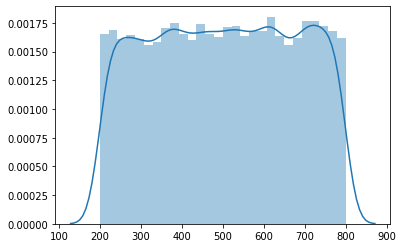

In [5]:
sns.distplot(data[:, 0])

In [12]:
example1= data[np.argmin(data[:, 0])]
example2 = data[np.argmax(data[:, 0])]

print("weakest drive", example1[0])
print("strongest drive ", example2[0])

weakest drive 200.015
strongest drive  800.0


In [8]:
total1 = example1[1:201] + example1[201:]
total2 = example2[1:201] + example2[201:]

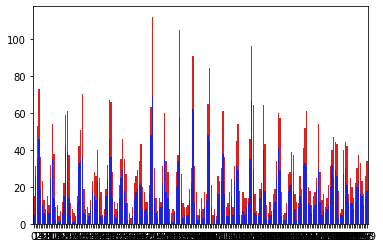

In [13]:
# weak drive. Very polarized
sns.barplot(list(range(0,200)), total1, color='red')
sns.barplot(list(range(0,200)), example1[1:201], color='blue')

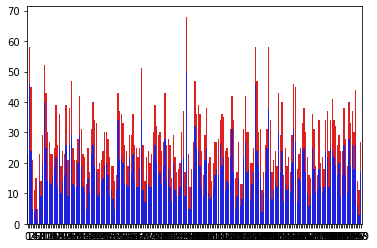

In [14]:
# strong drive. More uniform
sns.barplot(list(range(0,200)), total2, color='red')
sns.barplot(list(range(0,200)), example2[1:201], color='blue')

In [23]:
## THE TIME DYNAMIC WARPING (the larger, the more different the time series is)
distance, path = fastdtw(total1, total2, dist=euclidean)
print("distance between series", distance)

distance between series 2171.0


The hypothesis in the paper is that the drive strongly determines how synchronized (distinct bands of firing at regular intervals) the population is. We will fix a configuration, and plot the `fastdtw` distance between it and other configurations against drive.

In [27]:
fixed_config = data[np.argmin(data[:, 0])]
fixed_spikes = fixed_config[1:201] + fixed_config[201:]
distances = []
for config in data[0:1000]:
    spikes = config[1:201] + config[201:]
    distance, path = fastdtw(fixed_spikes, spikes, dist=euclidean)
    distances.append(distance)

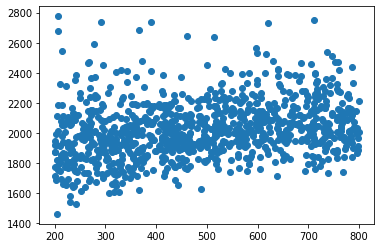

In [28]:
# x-axis: drive. y-axis: distances
plt.scatter(data[0:1000, 0], distances)

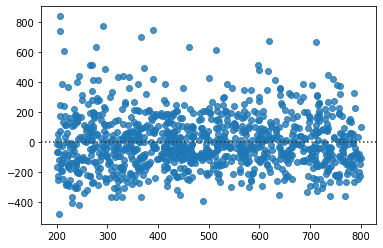

In [32]:
sns.residplot(data[0:1000, 0], distances)

In [36]:
cov = np.cov(data[0:1000, 0], distances, bias=True)
print(cov)

[[29923.91672564  8640.07164646]
 [ 8640.07164646 36280.420924  ]]


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Neural network (Hyperopt)

In [6]:
## optimize for specific learning rate
def objective(hps, X_train, y_train, X_test, y_test):
    mlp = MLPRegressor(hidden_layer_sizes=(1024, 1024), alpha=0.01, \
                  early_stopping=True, **hps)
    
    mlp.fit(X_train, y_train)
    
    y_pred = mlp.predict(X_test)
    return mae(y_pred, y_test)

In [81]:
hp_space = {'learning_rate_init': hp.loguniform('learning_rate_init', \
                                    np.log(1e-6), np.log(1))}

In [80]:
# visualize the sampling process of hyperspace

learning_rate_dist = []

for _ in range(100):
    learning_rate_dist.append(sample(hp_space)['learning_rate_init'])

KeyError: 'learning_rate_init'

In [59]:
learning_rate_dist

[0.0007007075101826231,
 0.010513033038661346,
 0.00537784047831775,
 0.007241341517466964,
 0.02029240805808318,
 6.54043937032526e-05,
 5.6873717647453815e-05,
 0.00026628910452867614,
 0.1467002704272912,
 3.059813387549056e-06,
 4.0590449856742505e-06,
 0.1471641874050507,
 0.2142293173569102,
 0.00012591951242209849,
 0.0064539140337582885,
 2.8600802517496563e-06,
 1.6151537341229158e-05,
 0.001371200360742555,
 0.5845970069543636,
 8.884065176793393e-05,
 4.212290585614246e-05,
 0.028604981345922143,
 0.17945167604214562,
 2.0068143844043978e-06,
 2.9285220290064027e-05,
 1.13661516221743e-05,
 7.504191430516813e-06,
 0.08286719487501451,
 0.005658555948393084,
 2.5638216665270053e-05,
 1.676062303661668e-06,
 0.012860759574740276,
 5.633524794134766e-05,
 0.3775918442137346,
 0.1701108725783611,
 2.7450884955249546e-05,
 0.0006309705444488385,
 0.06836696105180581,
 1.5069535338608968e-06,
 0.01924297233348128,
 0.03940525330616568,
 0.0008154729831427748,
 0.00413599993832005,

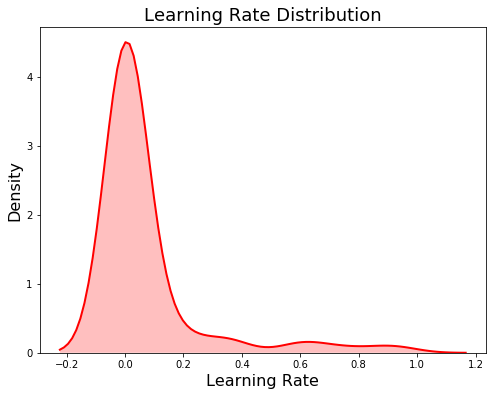

In [67]:
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', \
            linewidth = 2, shade = True)
plt.title('Learning Rate Distribution', size = 18)
plt.xlabel('Learning Rate', size = 16)
plt.ylabel('Density', size = 16)

plt.show()

In [75]:
SEED = 1
n_evals = 1000

In [77]:
trls = Trials()

In [ ]:
best_model = fmin(partial(objective, X_train=X_train, y_train=y_train, \
                        X_test=X_test, y_test=y_test), \
                  hp_space, algo=tpe.suggest, \
                  max_evals=n_evals, trials=trls,\
                  rstate = np.random.RandomState(SEED))


  0%|          | 1/1000 [12:59<216:16:48, 779.39s/it, best loss: 86.653247716864]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



  1%|          | 11/1000 [1:05:48<123:26:24, 449.33s/it, best loss: 76.58558019604368]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



  1%|▏         | 14/1000 [1:27:41<129:31:12, 472.89s/it, best loss: 76.58558019604368]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



  3%|▎         | 26/1000 [2:29:34<121:05:34, 447.57s/it, best loss: 76.29600005265567]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



  3%|▎         | 32/1000 [3:47:17<278:03:11, 1034.08s/it, best loss: 76.29600005265567]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



  4%|▍         | 44/1000 [4:44:34<108:31:45, 408.69s/it, best loss: 75.50181030970217] 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



  6%|▌         | 57/1000 [5:48:51<93:16:14, 356.07s/it, best loss: 75.40558167735999] 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



  6%|▌         | 62/1000 [6:19:57<114:08:31, 438.07s/it, best loss: 75.40558167735999]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



  7%|▋         | 74/1000 [7:27:47<126:50:12, 493.10s/it, best loss: 74.12896802142345]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



  9%|▊         | 86/1000 [8:26:40<101:06:39, 398.25s/it, best loss: 74.12896802142345]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



  9%|▉         | 90/1000 [8:55:12<118:20:44, 468.18s/it, best loss: 74.12896802142345]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



  9%|▉         | 92/1000 [9:17:42<147:03:09, 583.03s/it, best loss: 74.12896802142345]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 10%|▉         | 96/1000 [9:45:14<126:53:44, 505.34s/it, best loss: 74.12896802142345]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 10%|█         | 102/1000 [10:25:26<128:34:27, 515.44s/it, best loss: 74.12896802142345]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 13%|█▎        | 129/1000 [12:46:07<102:23:04, 423.17s/it, best loss: 74.12896802142345]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 14%|█▎        | 135/1000 [13:19:08<98:55:49, 411.73s/it, best loss: 74.12896802142345] 

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 14%|█▎        | 136/1000 [13:32:07<125:16:00, 521.94s/it, best loss: 74.12896802142345]

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 14%|█▍        | 140/1000 [13:50:55<80:38:59, 337.60s/it, best loss: 74.12896802142345] 

## Manual fit

In [38]:
mlp = MLPRegressor(hidden_layer_sizes=(2048, 2048))

In [39]:
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(2048, 2048), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [40]:
y_pred_train = mlp.predict(X_train)
y_pred_test = mlp.predict(X_test)
print('mae train', mae(y_pred_train, y_train))
print('mae test', mae(y_pred_test, y_test))

mae train 30.706532329608613
mae test 74.53541590126322


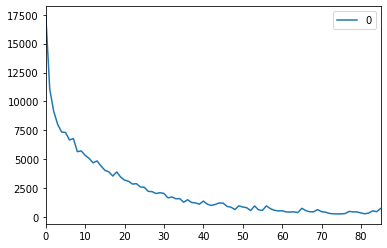

In [41]:
pd.DataFrame(mlp.loss_curve_).plot()

In [44]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
print('mae train', mae(y_pred_train, y_train))
print('mae test', mae(y_pred_test, y_test))

mae train 41.010386115555555
mae test 110.16038896500001


In [45]:
svr = svm.SVR()

svr.fit(X_train, y_train)
y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)
print('mae train', mae(y_pred_train, y_train))
print('mae test', mae(y_pred_test, y_test))


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


mae train 148.615929560866
mae test 149.26765197058825
